In [1]:
%matplotlib inline
import os.path as osp
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio

import mpet.mod_cell as mod_cell
import mpet.geometry as geom
import mpet.props_am as props_am
import mpet.utils as utils
from mpet.config import Config, constants

import os

c:\programdata\anaconda3.6\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def plot_interface(resultDir, vol, part, var, tval):
    matfile = osp.join(resultDir, 'output_data.mat')
    sim_output = sio.loadmat(matfile)
    times = sim_output['phi_applied_times'][0]
    config = Config.from_dicts(resultDir)

    Nvol = config["Nvol"]
    trodes = config["trodes"]
    Npart = config["Npart"]
    psd_len = config["psd_len"]

    # Pick out some useful calculated values
    k = constants.k                      # Boltzmann constant, J/(K Li)
    Tref = constants.T_ref               # Temp, K
    e = constants.e                      # Charge of proton, C
    F = constants.F                      # C/mol
    c_ref = constants.c_ref
    td = config["t_ref"]
    Etheta = {"a": 0.}
    for trode in trodes:
        Etheta[trode] = -(k*Tref/e) * config[trode, "phiRef"]
    Vstd = Etheta["c"] - Etheta["a"]
    
    trode = 'c'
    t = np.argmin(np.abs(times - tval))
    if tval > times[-1]:
        raise ValueError(f'Max time: {times[-1]}, got {tval}')
    
    var_names = {'c': 'concentration',
                 'phi': 'potential'}
    var_long = var_names[var]
    
    fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(8, 4))
    
    key = f'interfaceTrode{trode}vol{vol}part{part}_{var}'
    nvol_i = sim_output[key].shape[1]
    
    Lfac = 1e6
    Lunit = r"$\mu$m"
    dxc = config["L"]["c"]/Nvol["c"]
    dxvec = np.array(Nvol["c"] * [dxc])
    porosvec = np.array(Nvol["c"] * [config["poros"]["c"]])
    cellsvec = dxc*np.arange(Nvol["c"]) + dxc/2.
    cellsvec_c = dxc*np.arange(Nvol["c"]) + dxc/2.
    cellsvec_c *=config["L_ref"] * Lfac
    
    dxs = config["L_i"]/nvol_i
    dxvec_i = np.array(nvol_i * [dxs])
    dxvec = np.hstack((dxvec_i, dxvec))
    poros_i = np.array(nvol_i * [config["poros_i"]])
    cellsvec += config["L_i"] / config["L"]["c"]
    cellsvec_i = dxs*np.arange(nvol_i) + dxs/2.
    cellsvec_i *= config["L_ref"] * Lfac

    # elyte data
    key = f'{var}_lyte_{trode}'
    if var in 'c':
        data_elyte = sim_output[key][:, vol]* c_ref / 1000.  # select correct elyte volume
    elif var in 'phi':
        data_elyte = sim_output[key][:, vol]*(k*Tref/e) - Vstd  # select correct elyte volume
    # elyte value at timestep chosen to plot interface region volumes
    cval = data_elyte[t]
    data_elyte_vol = sim_output[key][t]  # all volumes at given t
    
    # interface data
    key = f'interfaceTrode{trode}vol{vol}part{part}_{var}'
    # select all time steps, middle volume
    ind = int(nvol_i / 2)
    if var in 'c':
        data_iface = data_elyte = sim_output[key][:, vol]* c_ref / 1000.  # select correct elyte volume
        data_iface_vol = sim_output[key][t]* c_ref / 1000.
    elif var in 'phi':
        data_iface = sim_output[key][:, vol]*(k*Tref/e) - Vstd  # select correct elyte volume
        data_iface_vol = sim_output[key][t]*(k*Tref/e) - Vstd  # all volumes at given t
    
    # time vs variable
    ax = axes[0]
    ax.plot(times, data_elyte, label='elyte')
    ax.plot(times, data_iface, label='iface central volume')

    ax.set_xlabel('time')
    ax.set_ylabel(var_long)
    ax.axvline(tval, ls='--', c='k')
    ax.axhline(cval, ls='--', c='k')
    ax.legend()
    ax.set_title('Time evolution')

    #  volume vs variable
    ax = axes[1]   
#     ax.plot(data_iface_vol, marker='o', label='iface volumes')
    ax.plot(cellsvec_i,data_iface_vol, marker='o', label='iface volumes',c='m')
    ax.scatter(-cellsvec_i[0], cval, label='elyte output')
    print(var_long, "elyte", cval)
    print(var_long, "iface", data_iface_vol)
    ax.set_xlabel('Interface position [um]')
    ax.legend()
    ax.set_title('Interface volumes')
#     ax.set_ylim(-2, 2)

    fig.suptitle(var_long)
    fig.tight_layout()
    
    return sim_output

In [3]:
# to run mpet from jupyter
#!mpetrun.py mpet-dev/configs/params_system_solid.cfg # >/dev/null; echo $?

concentration elyte 0.4881030731623214
concentration iface [0.494095   0.49407404 0.49403212 0.49396924]
potential elyte -3.366237620769674
potential iface [-3.36623932 -3.36624198 -3.3662456  -3.36625019]


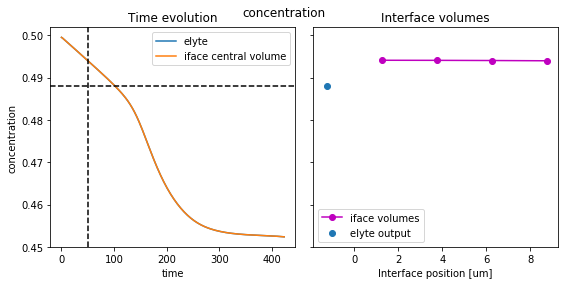

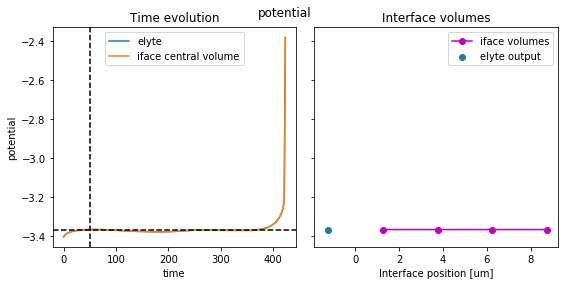

In [4]:
resultDir = 'sim_output'
vol = 0  # volume to plot
part = 0  # particle to plot
tval = 50  # which timestep to show (in seconds)

for var in ['c', 'phi']:
    sim_output = plot_interface(resultDir, vol, part, var, tval)

In [5]:
def plot_phi_i(resultDir, vol, part, var, tval):
    matfile = osp.join(resultDir, 'output_data.mat')
    sim_output = sio.loadmat(matfile)
    times = sim_output['phi_applied_times'][0]
    config = Config.from_dicts(resultDir)

    Nvol = config["Nvol"]
    trodes = config["trodes"]
    Npart = config["Npart"]
    psd_len = config["psd_len"]

    # Pick out some useful calculated values
    k = constants.k                      # Boltzmann constant, J/(K Li)
    Tref = constants.T_ref               # Temp, K
    e = constants.e                      # Charge of proton, C
    F = constants.F                      # C/mol
    c_ref = constants.c_ref
    td = config["t_ref"]
    Etheta = {"a": 0.}
    for trode in trodes:
        Etheta[trode] = -(k*Tref/e) * config[trode, "phiRef"]
    Vstd = Etheta["c"] - Etheta["a"]
    
    trode = 'c'
    t = np.argmin(np.abs(times - tval))
    if tval > times[-1]:
        raise ValueError(f'Max time: {times[-1]}, got {tval}')
    
    var_names = {'c': 'concentration',
                 'phi': 'potential'}
    var_long = var_names[var]
    
    fig, axes = plt.subplots(ncols=1, sharey=True, figsize=(8, 4))
    
    key = f'interfaceTrode{trode}vol{vol}part{part}_{var}'
    nvol_i = sim_output[key].shape[1]
    
    Lfac = 1e6
    Lunit = r"$\mu$m"
    dxc = config["L"]["c"]/Nvol["c"]
    dxvec = np.array(Nvol["c"] * [dxc])
    porosvec = np.array(Nvol["c"] * [config["poros"]["c"]])
    cellsvec = dxc*np.arange(Nvol["c"]) + dxc/2.
    cellsvec_c = dxc*np.arange(Nvol["c"]) + dxc/2.
    cellsvec_c *=config["L_ref"] * Lfac
    
    dxs = config["L_i"]/nvol_i
    dxvec_i = np.array(nvol_i * [dxs])
    dxvec = np.hstack((dxvec_i, dxvec))
    poros_i = np.array(nvol_i * [config["poros_i"]])
    cellsvec += config["L_i"] / config["L"]["c"]
    cellsvec_i = dxs*np.arange(nvol_i) + dxs/2.
    cellsvec_i *= config["L_ref"] * Lfac

    # elyte data
    key = f'{var}_lyte_{trode}'
    if var in 'c':
        data_elyte = sim_output[key][:, vol]* c_ref / 1000.  # select correct elyte volume
    elif var in 'phi':
        data_elyte = sim_output[key][:, vol]*(k*Tref/e) - Vstd  # select correct elyte volume
    # elyte value at timestep chosen to plot interface region volumes
    cval = data_elyte[t]
    data_elyte_vol = sim_output[key][t]  # all volumes at given t
    
    # interface data
    key = f'interfaceTrode{trode}vol{vol}part{part}_{var}'
    # select all time steps, middle volume
    ind = int(nvol_i / 2)
    if var in 'c':
        data_iface = data_elyte = sim_output[key][:, vol]* c_ref / 1000.  # select correct elyte volume
        data_iface_vol = sim_output[key][t]* c_ref / 1000.
    elif var in 'phi':
        data_iface = sim_output[key][:, vol]*(k*Tref/e) - Vstd  # select correct elyte volume
        data_iface_vol = sim_output[key][t]*(k*Tref/e) - Vstd  # all volumes at given t

    #  volume vs variable
    ax = plt  
#     ax.plot(data_iface_vol, marker='o', label='iface volumes')
    ax.plot(cellsvec_i,data_iface_vol, marker='o', label='iface volumes',c='m')
    ax.scatter(-cellsvec_i[0], cval, label='elyte output')
    print(var_long, "elyte", cval)
    print(var_long, "iface", data_iface_vol)
    ax.xlabel('Interface position [um]')
    ax.legend()
    ax.title('Interface volumes')
#     ax.set_ylim(-2, 2)

    fig.suptitle(var_long)
    fig.tight_layout()
    
    return sim_output

potential elyte -3.366237620769674
potential iface [-3.36623932 -3.36624198 -3.3662456  -3.36625019]


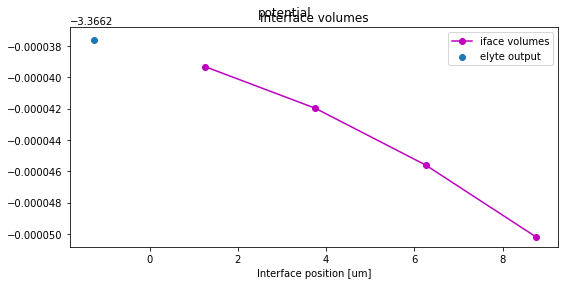

In [6]:
resultDir = 'sim_output'
vol = 0  # volume to plot
part = 0  # particle to plot
tval = 50  # which timestep to show (in seconds)

for var in ['phi']:
    sim_output = plot_phi_i(resultDir, vol, part, var, tval)

In [7]:
def plot_battery(resultDir, vol, part, var, tval):
    matfile = osp.join(resultDir, 'output_data.mat')
    sim_output = sio.loadmat(matfile)
    times = sim_output['phi_applied_times'][0]
    config = Config.from_dicts(resultDir)

    Nvol = config["Nvol"]
    trodes = config["trodes"]
    Npart = config["Npart"]
    psd_len = config["psd_len"]
    dD_e = {}
    ndD_e = {}

    # Pick out some useful calculated values
    k = constants.k                      # Boltzmann constant, J/(K Li)
    Tref = constants.T_ref               # Temp, K
    e = constants.e                      # Charge of proton, C
    F = constants.F                      # C/mol
    c_ref = constants.c_ref
    td = config["t_ref"]
    Etheta = {"a": 0.}
    for trode in trodes:
        Etheta[trode] = -(k*Tref/e) * config[trode, "phiRef"]
    Vstd = Etheta["c"] - Etheta["a"]
    
    Lfac = 1e6
    Lunit = r"$\mu$m"
    dxc = config["L"]["c"]/Nvol["c"]
    dxvec = np.array(Nvol["c"] * [dxc])
    porosvec = np.array(Nvol["c"] * [config["poros"]["c"]])
    cellsvec = dxc*np.arange(Nvol["c"]) + dxc/2.
    cellsvec_c = dxc*np.arange(Nvol["c"]) + dxc/2.
    cellsvec_c *= config["L_ref"] * Lfac
    if Nvol["s"]:
        dxs = config["L"]["s"]/Nvol["s"]
        dxvec_s = np.array(Nvol["s"] * [dxs])
        dxvec = np.hstack((dxvec_s, dxvec))
        poros_s = np.array(Nvol["s"] * [config["poros"]["s"]])
        porosvec = np.hstack((poros_s, porosvec))
        cellsvec += config["L"]["s"] / config["L"]["c"]
        cellsvec_s = dxs*np.arange(Nvol["s"]) + dxs/2.
        cellsvec = np.hstack((cellsvec_s, cellsvec))
    if "a" in trodes:
        dxa = config["L"]["a"]/Nvol["a"]
        dxvec_a = np.array(Nvol["a"] * [dxa])
        dxvec = np.hstack((dxvec_a, dxvec))
        poros_a = np.array(Nvol["a"] * [config["poros"]["a"]])
        porosvec = np.hstack((poros_a, porosvec))
        cellsvec += config["L"]["a"] / config["L"]["c"]
        cellsvec_a = dxa*np.arange(Nvol["a"]) + dxa/2.
        cellsvec = np.hstack((cellsvec_a, cellsvec))
    cellsvec_s *= config["L_ref"] * Lfac
    cellsvec *= config["L_ref"] * Lfac
    facesvec = np.insert(np.cumsum(dxvec), 0, 0.) * config["L_ref"] * Lfac
    
    # Uncomment these lines to show the variables you can plot
    # for k in sim_output.keys():
    #     print(k)
    # return

    trode = 'c'
    t = np.argmin(np.abs(times - tval))
    if tval > times[-1]:
        raise ValueError(f'Max time: {times[-1]}, got {tval}')
    
    var_names = {'c': 'concentration',
                 'phi': 'potential'}
    var_long = var_names[var]
    
    fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(8, 4))

    # elyte data elyte
    key = f'{var}_lyte_s'
    if var in 'c':
        data_elyte_s = sim_output[key]* c_ref / 1000.  # select correct elyte volume
    elif var in 'phi':
        data_elyte_s = sim_output[key]*(k*Tref/e) - Vstd
    x_elyte_s = list(range(-np.shape(data_elyte_s)[1],0))
    # elyte value at timestep chosen to plot interface region volumes
    if var in 'c':
        cval_s = data_elyte_s[t]
    elif var in 'phi':
        cval_s = data_elyte_s[t]
    data_elyte_vol_s = sim_output[key][t]  # all volumes at given t
    
    # elyte data electrode
    key = f'{var}_lyte_{trode}'
    if var in 'c':
        data_elyte_c = sim_output[key]* c_ref / 1000.  # select correct elyte volume
    elif var in 'phi':
        data_elyte_c = sim_output[key]*(k*Tref/e) - Vstd
    x_elyte_c = list(range(np.shape(data_elyte_c)[1]))
    # elyte value at timestep chosen to plot interface region volumes
    if var in 'c':
        cval_c = data_elyte_c[t]
    elif var in 'phi':
        cval_c = data_elyte_c[t]
    data_elyte_vol_c = sim_output[key][t]  # all volumes at given t
    
    # time vs variable
    ax = axes[0]
    ax.plot(times, data_elyte_c)
    ax.plot(times, data_elyte_s[:,-1], label='elyte_s last volume')

    ax.set_xlabel('time')
    ax.set_ylabel(var_long)
    ax.axvline(tval, ls='--', c='k')
#    ax.axhline(cval_c, ls='--', c='k')
    ax.legend()
    ax.set_title('Time evolution')

    #  volume vs variable
    ax = axes[1]   
#     ax.plot(x_elyte_c,cval_c, marker='o', label='elyte_c')
#     ax.plot(x_elyte_s,cval_s , label='elyte_s', c='g', marker='o')
    
#     datay = np.hstack((cval_s, cval_c))
#     ax.plot(cellsvec,datay , label='elyte_s', c='g', marker='o')
    
    ax.plot(cellsvec_s[-1]+cellsvec_c,cval_c, marker='o', label='elyte_c')
    ax.plot(cellsvec_s,cval_s , label='elyte_s', c='g', marker='o')
    
    ax.set_xlabel('Battery position [um]')
    ax.legend()
#    ax.set_ylim(0, 0.7)

    fig.suptitle(var_long)
    fig.tight_layout()
    
    return sim_output



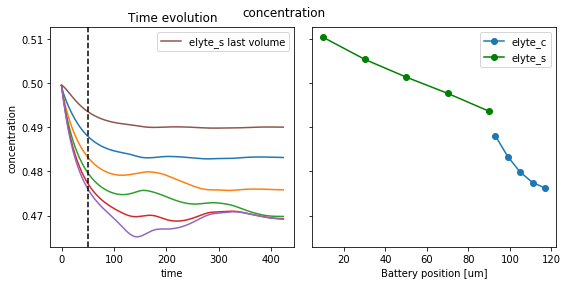

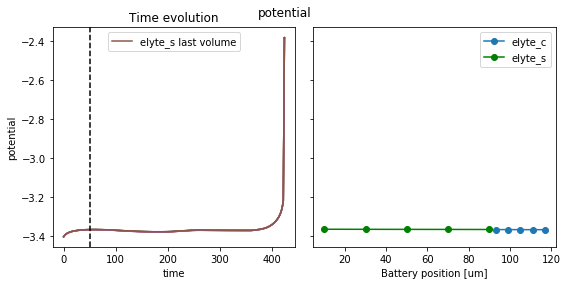

In [8]:
resultDir = 'sim_output'
vol = 0  # volume to plot
part = 3  # particle to plot
tval = 50  # which timestep to show (in seconds)

for var in ['c', 'phi']:
    sim_output = plot_battery(resultDir, vol, part, var, tval)


In [9]:
def plot_phi(resultDir, vol, part, var, tval):
    matfile = osp.join(resultDir, 'output_data.mat')
    sim_output = sio.loadmat(matfile)
    times = sim_output['phi_applied_times'][0]
    config = Config.from_dicts(resultDir)

    Nvol = config["Nvol"]
    trodes = config["trodes"]
    Npart = config["Npart"]
    psd_len = config["psd_len"]
    dD_e = {}
    ndD_e = {}

    # Pick out some useful calculated values
    k = constants.k                      # Boltzmann constant, J/(K Li)
    Tref = constants.T_ref               # Temp, K
    e = constants.e                      # Charge of proton, C
    F = constants.F                      # C/mol
    c_ref = constants.c_ref
    td = config["t_ref"]
    Etheta = {"a": 0.}
    for trode in trodes:
        Etheta[trode] = -(k*Tref/e) * config[trode, "phiRef"]
    Vstd = Etheta["c"] - Etheta["a"]
    
    Lfac = 1e6
    Lunit = r"$\mu$m"
    dxc = config["L"]["c"]/Nvol["c"]
    dxvec = np.array(Nvol["c"] * [dxc])
    porosvec = np.array(Nvol["c"] * [config["poros"]["c"]])
    cellsvec = dxc*np.arange(Nvol["c"]) + dxc/2.
    cellsvec_c = dxc*np.arange(Nvol["c"]) + dxc/2.
    cellsvec_c *= config["L_ref"] * Lfac
    if Nvol["s"]:
        dxs = config["L"]["s"]/Nvol["s"]
        dxvec_s = np.array(Nvol["s"] * [dxs])
        dxvec = np.hstack((dxvec_s, dxvec))
        poros_s = np.array(Nvol["s"] * [config["poros"]["s"]])
        porosvec = np.hstack((poros_s, porosvec))
        cellsvec += config["L"]["s"] / config["L"]["c"]
        cellsvec_s = dxs*np.arange(Nvol["s"]) + dxs/2.
        cellsvec = np.hstack((cellsvec_s, cellsvec))
    if "a" in trodes:
        dxa = config["L"]["a"]/Nvol["a"]
        dxvec_a = np.array(Nvol["a"] * [dxa])
        dxvec = np.hstack((dxvec_a, dxvec))
        poros_a = np.array(Nvol["a"] * [config["poros"]["a"]])
        porosvec = np.hstack((poros_a, porosvec))
        cellsvec += config["L"]["a"] / config["L"]["c"]
        cellsvec_a = dxa*np.arange(Nvol["a"]) + dxa/2.
        cellsvec = np.hstack((cellsvec_a, cellsvec))
    cellsvec_s *= config["L_ref"] * Lfac
    cellsvec *= config["L_ref"] * Lfac
    facesvec = np.insert(np.cumsum(dxvec), 0, 0.) * config["L_ref"] * Lfac
    
    # Uncomment these lines to show the variables you can plot
    # for k in sim_output.keys():
    #     print(k)
    # return

    trode = 'c'
    t = np.argmin(np.abs(times - tval))
    if tval > times[-1]:
        raise ValueError(f'Max time: {times[-1]}, got {tval}')
    
    var_names = {'c': 'concentration',
                 'phi': 'potential'}
    var_long = var_names[var]
    
    fig, axes = plt.subplots(ncols=1, sharey=True, figsize=(8, 4))

    # elyte data elyte
    key = f'{var}_lyte_s'
    if var in 'c':
        data_elyte_s = sim_output[key]* c_ref / 1000.  # select correct elyte volume
    elif var in 'phi':
        data_elyte_s = sim_output[key]*(k*Tref/e) - Vstd
    x_elyte_s = list(range(-np.shape(data_elyte_s)[1],0))
    # elyte value at timestep chosen to plot interface region volumes
    if var in 'c':
        cval_s = data_elyte_s[t]
    elif var in 'phi':
        cval_s = data_elyte_s[t]
    data_elyte_vol_s = sim_output[key][t]  # all volumes at given t
    
    # elyte data electrode
    key = f'{var}_lyte_{trode}'
    if var in 'c':
        data_elyte_c = sim_output[key]* c_ref / 1000.  # select correct elyte volume
    elif var in 'phi':
        data_elyte_c = sim_output[key]*(k*Tref/e) - Vstd
    x_elyte_c = list(range(np.shape(data_elyte_c)[1]))
    # elyte value at timestep chosen to plot interface region volumes
    if var in 'c':
        cval_c = data_elyte_c[t]
    elif var in 'phi':
        cval_c = data_elyte_c[t]
    data_elyte_vol_c = sim_output[key][t]  # all volumes at given t

    #  volume vs variable
    ax = plt   
#     ax.plot(x_elyte_c,cval_c, marker='o', label='elyte_c')
#     ax.plot(x_elyte_s,cval_s , label='elyte_s', c='g', marker='o')
    
#     datay = np.hstack((cval_s, cval_c))
#     ax.plot(cellsvec,datay , label='elyte_s', c='g', marker='o')
    
    ax.plot(cellsvec_s[-1]+cellsvec_c,cval_c, marker='o', label='elyte_c')
    ax.plot(cellsvec_s,cval_s , label='elyte_s', c='g', marker='o')
    
    ax.xlabel('Battery position [um]')
    ax.legend()
#    ax.set_ylim(0, 0.7)

    fig.suptitle(var_long)
    fig.tight_layout()
    
    return sim_output


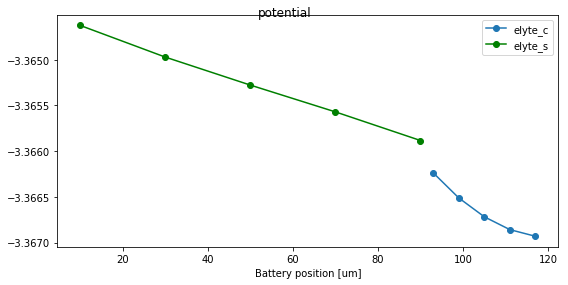

In [10]:
resultDir = 'sim_output'
vol = 0  # volume to plot
part = 3  # particle to plot
tval = 50  # which timestep to show (in seconds)

for var in ['phi']:
    sim_output = plot_phi(resultDir, vol, part, var, tval)

In [7]:
def plot_i(resultDir, vol, part, var, tval):
    matfile = osp.join(resultDir, 'output_data.mat')
    sim_output = sio.loadmat(matfile)
    times = sim_output['phi_applied_times'][0]
    numtimes = len(times)
    config = Config.from_dicts(resultDir)

    Nvol = config["Nvol"]
    trodes = config["trodes"]
    Npart = config["Npart"]
    psd_len = config["psd_len"]
    
    # Pick out some useful calculated values
    k = constants.k                      # Boltzmann constant, J/(K Li)
    Tref = constants.T_ref               # Temp, K
    e = constants.e                      # Charge of proton, C
    F = constants.F                      # C/mol
    c_ref = constants.c_ref
    
    # Uncomment these lines to show the variables you can plot
    for k in sim_output.keys():
        print(k)
    return

    trode = 'c'
    t = np.argmin(np.abs(times - tval))
    if tval > times[-1]:
        raise ValueError(f'Max time: {times[-1]}, got {tval}')
    
    var_names = {'c': 'concentration',
                 'phi': 'potential'}
    var_long = var_names[var]
    
    key = f'interfaceTrode{trode}vol{vol}part{part}_{var}'
    nvol_i = sim_output[key].shape[1]
    
    Lfac = 1e6
    Lunit = r"$\mu$m"
    dxc = config["L"]["c"]/Nvol["c"]
    dxvec = np.array(Nvol["c"] * [dxc])
    porosvec = np.array(Nvol["c"] * [config["poros"]["c"]])
    cellsvec = dxc*np.arange(Nvol["c"]) + dxc/2.
    cellsvec_c = dxc*np.arange(Nvol["c"]) + dxc/2.
    cellsvec_c *=config["L_ref"] * Lfac
    
    dxs = config["L_i"]/nvol_i
    dxvec_i = np.array(nvol_i * [dxs])
    dxvec = np.hstack((dxvec_i, dxvec))
    poros_i = np.array(nvol_i * [config["poros_i"]])
    cellsvec += config["L_i"] / config["L"]["c"]
    cellsvec_i = dxs*np.arange(nvol_i) + dxs/2.
    cellsvec_i *= config["L_ref"] * Lfac
    facesvec_i = np.insert(np.cumsum(dxvec_i), 0, 0.) * config["L_ref"] * Lfac

    t = np.argmin(np.abs(times - tval))
    if tval > times[-1]:
        raise ValueError(f'Max time: {times[-1]}, got {tval}')

    Nvol = config["Nvol_i"]
    
    key_c = f'interfaceTrodecvol{vol}part{part}_c'
    key_phi = f'interfaceTrodecvol{vol}part{part}_phi'

    cGP_L, pGP_L = sim_output['c_lyteGP_L'], sim_output['phi_lyteGP_L']
    c_int, phi_int = sim_output[key_c], sim_output[key_phi]
    cmat = np.hstack((c_int[:, 0].reshape((numtimes, 1)), c_int, c_int[:, -1].reshape((numtimes, 1))))
    pmat = np.hstack((phi_int[:, 0].reshape((numtimes, 1)), phi_int, phi_int[:, -1].reshape((numtimes, 1))))
    disc = geom.get_interface_disc(Nvol, config["L_i"], config["poros_i"], config["BruggExp_i"])

    i_edges = np.zeros((numtimes, np.shape(cmat)[1]-1))

    for tInd in range(numtimes):
        i_edges[tInd, :] = mod_cell.get_lyte_internal_fluxes(cmat[tInd, :], pmat[tInd, :], disc, config)[1]

    ylbl = r'Current density of interface [A/m$^2$]'
    datax = range(np.shape(cmat)[1]-1)
    datay = i_edges * (F*c_ref*config["D_ref"]/config["L_ref"])
    #datay = i_edges
    
    ax = axes[0]
    ax.plot(times,datay[:,1], marker='o')
    ax.axvline(tval, ls='--', c='k')
    ax.set_xlabel('time [s]')
    ax.set_ylabel(ylbl)
    
    ax = axes[1]
    #ax.plot(datax,datay[t,:], marker='o')
    ax.plot(facesvec_i,datay[t,:], marker='o')
    ax.set_xlabel('Interface position [um]')
    
    #total_current_i = np.zeros(5)
    #total_current_i = datay[t,:]
    #print(total_current_i)
    
    fig.suptitle('Current density')
    fig.tight_layout()
    
    return sim_output

__header__
__version__
__globals__
phi_applied_times
R_Vp_c
R_Vpp_c
c_lyteGP_L
c_lyte_c
c_lyte_s
current
ffrac_c
interfaceTrodecvol0part0_c
interfaceTrodecvol0part0_phi
interfaceTrodecvol0part1_c
interfaceTrodecvol0part1_phi
interfaceTrodecvol0part2_c
interfaceTrodecvol0part2_phi
interfaceTrodecvol0part3_c
interfaceTrodecvol0part3_phi
interfaceTrodecvol0part4_c
interfaceTrodecvol0part4_phi
interfaceTrodecvol1part0_c
interfaceTrodecvol1part0_phi
interfaceTrodecvol1part1_c
interfaceTrodecvol1part1_phi
interfaceTrodecvol1part2_c
interfaceTrodecvol1part2_phi
interfaceTrodecvol1part3_c
interfaceTrodecvol1part3_phi
interfaceTrodecvol1part4_c
interfaceTrodecvol1part4_phi
interfaceTrodecvol2part0_c
interfaceTrodecvol2part0_phi
interfaceTrodecvol2part1_c
interfaceTrodecvol2part1_phi
interfaceTrodecvol2part2_c
interfaceTrodecvol2part2_phi
interfaceTrodecvol2part3_c
interfaceTrodecvol2part3_phi
interfaceTrodecvol2part4_c
interfaceTrodecvol2part4_phi
interfaceTrodecvol3part0_c
interfaceTrodecvol3p

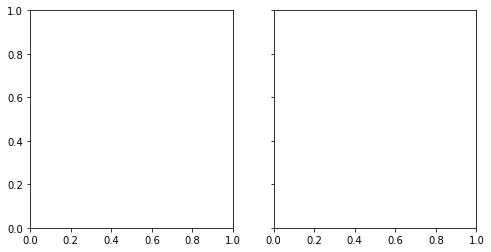

In [8]:
resultDir = 'sim_output'

fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(8, 4))

tval = 250  # which timestep to show (in seconds)

for vol in [0]:
    for part in [0]:
        sim_output = plot_i(resultDir, vol, part, var, tval)